In [1]:
### This file does a RZ gate (1 parameter, 1 qubit) with X,Y control
using QuantumCollocation
using NamedTrajectories
using TrajectoryIndexingUtils

In [2]:
const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units
;

In [3]:
# Operators
const Paulis = Dict(
    "I" => Matrix{ComplexF64}([1 0; 0 1]),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 im; -im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)
const a = [0 1; 0 0]
const ad = transpose(a);
excitation(theta) = exp(-im/2 * theta * Paulis["Z"]);


H_drives = [
     Paulis["Z"],
]
system = QuantumSystem(H_drives);
t_f = 10* ns
n_steps = 51
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
n_controls=1
n_qubits=1;
Δt = times[2] - times[1]

0.2

In [4]:
### Generate Initial Trajectories 
PICO_max_iter = 100

# Shape the cost function with weights on states and controls
Q = 1000.
R =1e-2
R_b=200.0
# Add control bounds
a_bound = 1.0
dda_bound = 1.0

ops = Options()
ops.print_info_string = "yes"
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1.0 ##down
ops.print_level = 0
p=UnitarySmoothPulseProblem(
                system,
                excitation(pi),
                n_steps,
                Δt;
                a_bound=a_bound,
                dda_bound=dda_bound,
                Q=Q,
                R=R,
                verbose=true,
                hessian_approximation=true,
                pade_order=10,
                free_time=true,
                timesteps_all_equal=true,
                max_iter=PICO_max_iter,
                ipopt_options=ops,
                )
min_time_problem  = UnitaryMinimumTimeProblem(p; final_fidelity=1-1e-5,max_iter=500);
solve!(min_time_problem)

    building dynamics from integrators...
        constructing knot point dynamics functions...
        determining dynamics derivative structure...
            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint

******************************************************************************
This pro

In [5]:
Δt = ceil(1.2 * min_time_problem.trajectory[:Δt][1]*100)/100

0.13

In [6]:
N = 11
trajectory_list,glued_trajectory_list = Interpolator1D(
    excitation,
    system,
    n_steps,
    N,
    Δt;
    Q=Q,
    R=R,
    R_b=R_b,
    a_bound=a_bound,
    dda_bound=dda_bound,
    ipopt_options=ops,
    max_iter=PICO_max_iter,
    fidelity_constraint = 1e-5
);

    building dynamics from integrators...
        constructing knot point dynamics functions...
        determining dynamics derivative structure...
            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
    building dynamics from integrators...
        constructing knot point dynamics functions...
        determining dynamics derivative structure...
            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a


In [7]:
DATA = sample1D(trajectory_list,Δt,n_qubits,system,2500,N,excitation)
findmax(DATA)

(9.325856570208124e-6, 251)

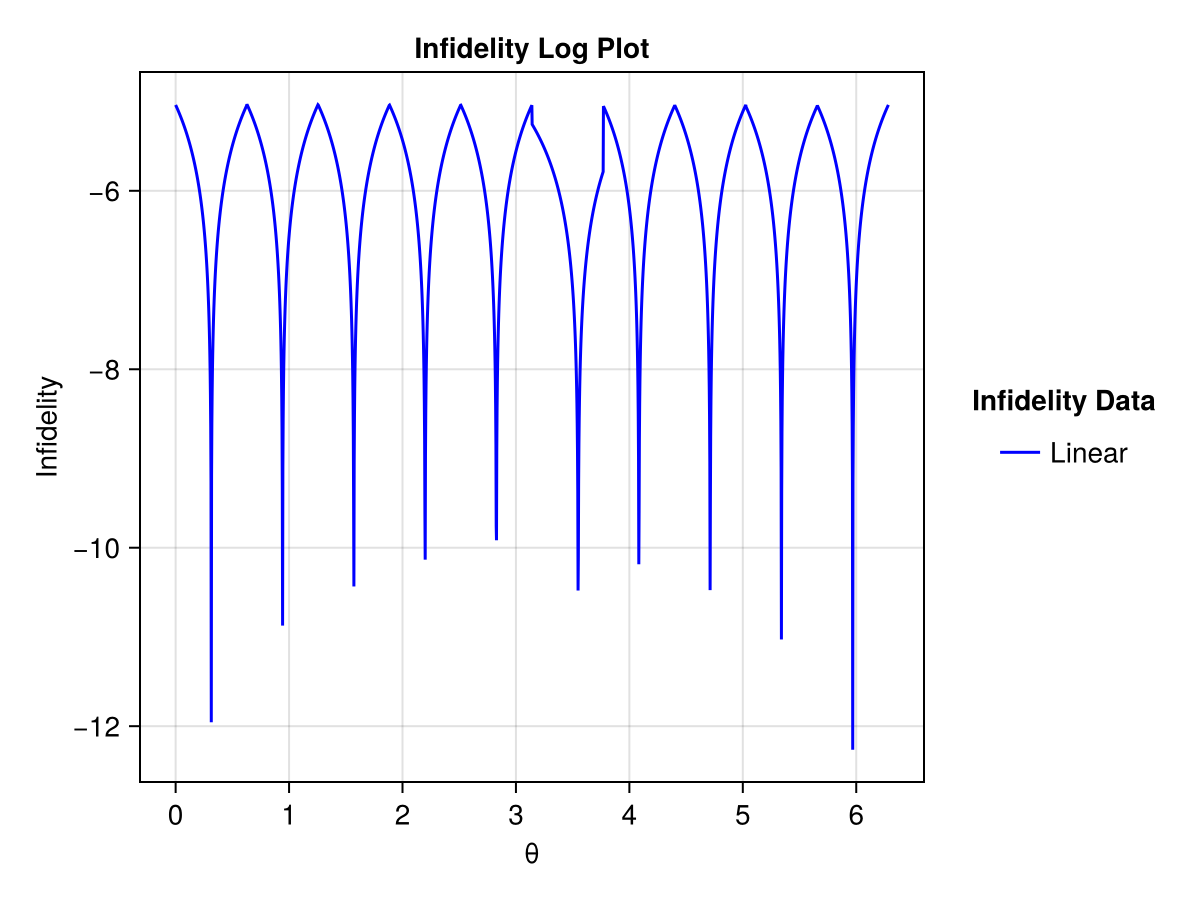

In [8]:
using CairoMakie
using Colors
using Printf
f = Figure()
ax = Axis(f[1, 1],
    title = "Infidelity Log Plot",
    xlabel = "θ",
    ylabel = "Infidelity"
)
lines!(ax, range(0,2*pi,convert(Int64,2500)), log10.(convert(Array{Float64,1},DATA)), label  = "Linear",color = :blue)


f[1, 2] = Legend(f, ax, "Infidelity Data", framevisible = false)
f
     

In [9]:
DATA = simple_sample1D(glued_trajectory_list,Δt,n_qubits,system,2500,N,excitation)
findmax(DATA)

(9.178996771885828e-6, 2500)

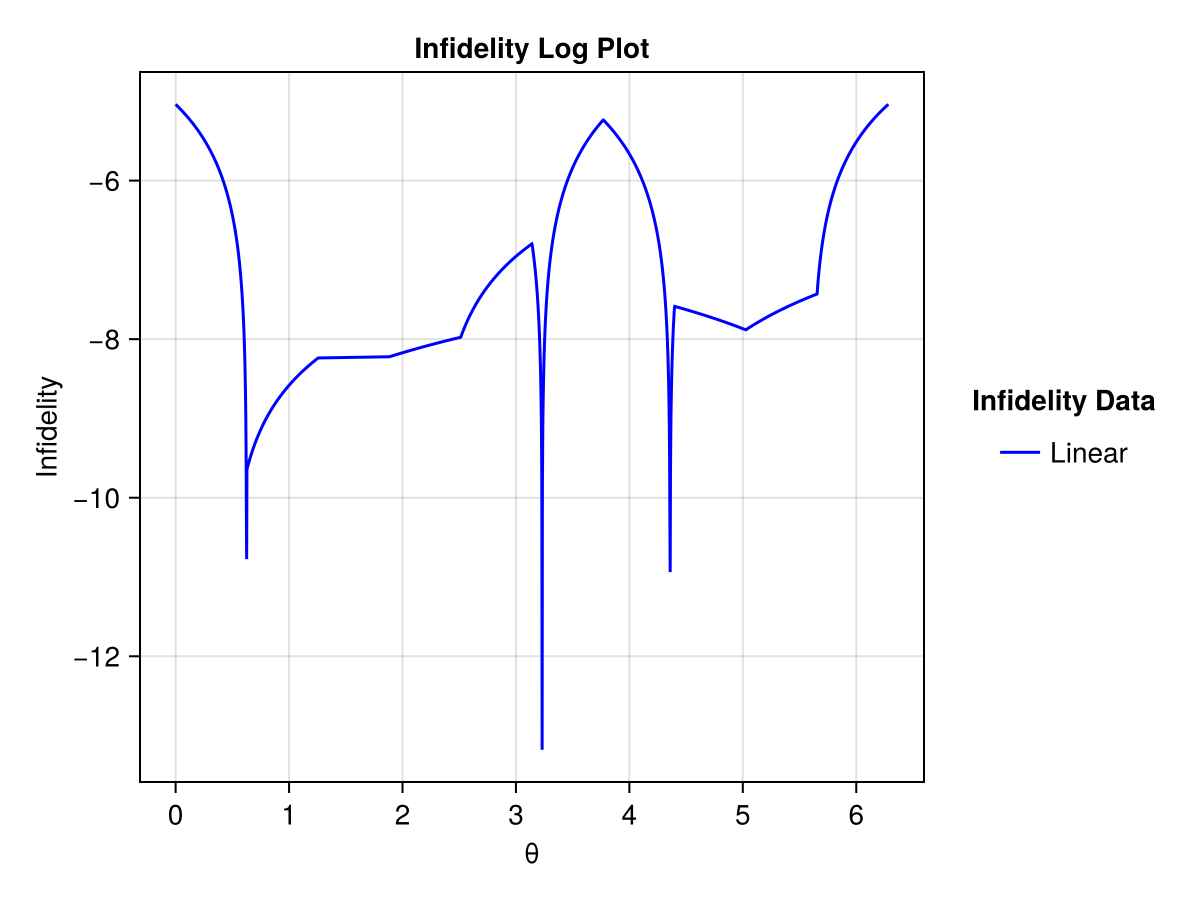

In [10]:
using CairoMakie
using Colors
using Printf
f = Figure()
ax = Axis(f[1, 1],
    title = "Infidelity Log Plot",
    xlabel = "θ",
    ylabel = "Infidelity"
)
lines!(ax, range(0,2*pi,convert(Int64,2500)), log10.(convert(Array{Float64,1},DATA)), label  = "Linear",color = :blue)

f[1, 2] = Legend(f, ax, "Infidelity Data", framevisible = false)
f
     

In [11]:
data,d_data,dd_data = parse1D(trajectory_list,n_controls,N);

In [12]:
verify1D(dd_data,n_qubits,system,Δt,n_steps,N,excitation)

9.16075343349032e-6
9.340801784052388e-6
9.17799651445339e-6
9.177047253450255e-6
9.174712991000256e-6
5.587007106067077e-6
8.968473569126445e-6
9.203793992162979e-6
8.85362583347149e-6
9.173245779425798e-6
9.178996771885828e-6


In [13]:
verify1D([t[:dda] for t in glued_trajectory_list],n_qubits,system,Δt,n_steps,N,excitation)

9.16075343349032e-6
2.2666013510530547e-10
5.793021617961358e-9
5.9991875911435955e-9
1.0566407415701917e-8
1.5966134725431402e-7
5.8323680316441084e-6
2.5959152605281588e-8
1.3113014896148911e-8
3.712584162318677e-8
9.178996771885828e-6


In [14]:
export_csv1D([t[:dda] for t in glued_trajectory_list],n_controls,N,"ZControlRZ_accels.csv")

"ZControlRZ_accels.csv"